# Customer loans in Finance

Here we test the class by first running an instance of the class under the variable 'test' and the input of our locally stored credentials.yaml file
Then we can run our methods from the test instance

In [2]:
#Here we import only the neccessary modules

import yaml
import pandas as pd
from sqlalchemy import create_engine, inspect
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import zscore
import sqlite3

#### The following is a method to transform the data

In [3]:
class DataTransform():

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    '''
    Check that all ids are unique
    '''

    def check_id_unique(self):
        
        num_unique_ids = loan_payments_table['id'].nunique()

        row_count = len(loan_payments_table)

        if num_unique_ids == row_count:
            print("All id's are unique")
        else:
            print("Not all of the id's are unique")

        return
    

    '''
    Turn a column from a str to an int
    '''

    def str_to_int(self):
        
        loan_payments_table['term'] = loan_payments_table['term'].dropna()

        loan_payments_table['term'] = loan_payments_table['term'].str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        return

#### The following is a class to connect to an RDS database and extract a loan payments dataframe and save it into a csv file

In [4]:
class RDSDatabaseConnector(DataTransform):

    '''
    Here we initialise the class with the only input needed is the 'credentials', which includes the details needed to access the RDS database
    
    '''

    def __init__(self, creds: dict):
        self.creds = creds

    '''
    The db_engine method is there to open the credentials file that is input by the user
    It extracts the various credentials and uses it to open the file; saving the out put into the engine variable
    The engine variable can be thought of as a key to access the database
    '''

    def db_engine(self):

        with open(self.creds, 'r') as file: #opening the yaml file input and creating an instance of the class in the variable self.creds_dict variable
            self.creds_dict = yaml.safe_load(file)
    
        DATABASE_TYPE = 'postgresql'
        DBAPI = 'psycopg2'
        ENDPOINT = self.creds_dict['RDS_HOST']
        USER = self.creds_dict['RDS_USER']
        PASSWORD = self.creds_dict['RDS_PASSWORD']
        PORT = 5432
        DATABASE = self.creds_dict['RDS_DATABASE']
        engine = create_engine(f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{ENDPOINT}:{PORT}/{DATABASE}")
        return engine
    
    '''
    The get_table_names does what it says on the tin, it gets the table names
    We use the built in inspect function from the sqlalchemy library to inspect the whole database
    Then the get_table_names() function returns a list of table names
    '''
    
    def get_table_names(self, engine):

        inspector = inspect(engine)

        return inspector.get_table_names()
    
    '''
    'loan payments' is the table we're looking for
    We use the engine along with the built in read_sql() function from the pandas library to assign the table to the variable 'loan_payments_table'
    '''
    
    def extract_data(self, engine):

        loan_payments_table = pd.read_sql('loan_payments', engine)

        return loan_payments_table
    
    ''''
    Now we can save that table to a csv file using the save_data() method
    '''
    
    def save_data(self, loan_payments_table):

        loan_payments_table.to_csv('df.csv')

        return
    
    '''
    To have an idea about what the data looks like,
    the show_data() method shows a snippet of the table with all the columns and a small number of rows
    '''
    
    def show_data(self, loan_payments_table):

        data_frame = pd.DataFrame(data=loan_payments_table)

        pd.set_option('display.max_rows', 30)

        pd.set_option('display.max_columns', None)

        print(data_frame)
        
        return

#### Now we run an instance of the class

In [5]:
test = RDSDatabaseConnector('credentials.yaml')

engine= test.db_engine() #get the key to the database using the credentials

table_names = test.get_table_names(engine) #use the key to get the table names

print(table_names) #view the table names

loan_payments_table = test.extract_data(engine) #use the key to access the loan payments table

test.show_data(loan_payments_table) # show a snippit of the data

test.save_data(loan_payments_table) #save the loan payments table to the csv file

['loan_payments']
             id  member_id  loan_amount  funded_amount  funded_amount_inv  \
0      38676116   41461848         8000         8000.0             8000.0   
1      38656203   41440010        13200        13200.0            13200.0   
2      38656154   41439961        16000        16000.0            16000.0   
3      38656128   41439934        15000        15000.0            15000.0   
4      38656121   41439927        15000        15000.0            15000.0   
...         ...        ...          ...            ...                ...   
54226     76597      76583         5000         5000.0             1775.0   
54227    142608      74724         5000         5000.0             2350.0   
54228    117045      70978         3500         3500.0             2225.0   
54229     88854      70699         5000         5000.0              225.0   
54230     72323      70694         5000         5000.0              350.0   

            term  int_rate  instalment grade sub_grade em

#### Use the following class to get information on the data

In [6]:
class DataFrameInfo:

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    '''
    Find the data types, median, standard deviation and mean
    '''

    def column_data_types(self):
        
        return loan_payments_table.dtypes
    
    def get_median(self):

        return loan_payments_table.median(numeric_only=True)

    def get_standard_deviation(self):

        return loan_payments_table.std(numeric_only=True)

    def get_mean(self):

        return loan_payments_table.mean(numeric_only=True)
    
    '''
    Count categorical values
    '''
    
    def count_categorical_values(self):

        loan_payments_column_names = list(loan_payments_table.columns)

        for column_name in loan_payments_column_names:

            if loan_payments_table[column_name].dtype == object:

                print(loan_payments_table[column_name].value_counts())
            
            else:

                pass

        return
    
    '''
    Find the shape and values
    '''
    
    def get_shape(self):

        return loan_payments_table.shape

#### The following class will plot the data

In [7]:
class Plotter:

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    '''
    Plot null values, skew and outliers
    '''
    
    def plot_null(self):

        loan_payments_table.isna().sum().plot(kind='bar')

        return
    
    def plot_skew(self):

        loan_payments_table.skew(numeric_only=True).plot(kind='bar')

    def plot_outliers(self):

        loan_payments_table.plot(kind='box', figsize=(16,12))

#### The following class is a data frame transformer class

In [8]:
class DataFrameTransform(RDSDatabaseConnector, Plotter):

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    
    '''
    Find the number of null values and proportion of null values
    '''

    def null_values(self):

        print("Percentage of null values:")

        print(loan_payments_table.isnull().sum() * 100 / len(loan_payments_table))

        print("Number of null values:")

        print(loan_payments_table.isna().sum())

        pd.options.display.max_rows = 4000

        return
    
    '''
    Drop the columns that are not needed
    '''
    
    def drop_columns(self):

        loan_payments_table.drop(columns='mths_since_last_delinq', inplace=True)

        loan_payments_table.drop(columns='mths_since_last_record', inplace=True)

        loan_payments_table.drop(columns='funded_amount', inplace=True)

        loan_payments_table.drop(columns='mths_since_last_major_derog', inplace=True)

        loan_payments_table.drop(columns='next_payment_date', inplace=True)

        return loan_payments_table
    
    '''
    Fill in the empty values with the mean or mode depending on which is most appropriate
    '''

    def impute_columns(self):

        int_rate_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['int_rate'].fillna(int_rate_mean, inplace=True)

        term_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['term'].fillna(term_mean, inplace=True)

        employment_length_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['employment_length'].fillna(employment_length_mean, inplace=True)

        collections_12_mths_ex_med_mean = loan_payments_table['collections_12_mths_ex_med'].mean(numeric_only=True)

        loan_payments_table['collections_12_mths_ex_med'].fillna(collections_12_mths_ex_med_mean, inplace=True)

        last_payment_date_mode = loan_payments_table['last_payment_date'].mode()[0]

        loan_payments_table['last_payment_date'].fillna(last_payment_date_mode, inplace=True)

        last_credit_pull_date_mode = loan_payments_table['last_credit_pull_date'].mode()[0]

        loan_payments_table['last_credit_pull_date'].fillna(last_credit_pull_date_mode, inplace=True)

        return
    
    '''
    Find the skewness of the dataset
    '''
    
    def skewness(self):

        print(loan_payments_table.skew(numeric_only=True))

        return
    
    '''
    Reduce the skew of the skewed columns identified from the previous method
    '''
    
    def reduce_skew(self):

        skewed_columns = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'out_prncp', 'out_prncp_inv',
                           'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
                           'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med']

        print(skewed_columns)

        for column in skewed_columns:

            loan_payments_table[column] = loan_payments_table[column].map(lambda i: np.log(i) if i > 0 else 0)

            return

        for column in skewed_columns:
    
            yeojohnson_column, _ = stats.yeojohnson(loan_payments_table[column])

            loan_payments_table[column] = yeojohnson_column 

            return    #works to get most of the skewed

        return
    
    '''
    Identify the outliers and remove them
    '''

    def remove_outliers(self, column):
        
        z_scores = zscore(loan_payments_table[column].astype(int))

        loan_payments_table.loc[abs(z_scores) > 3, column] = loan_payments_table[column].mean()

        print(column)

        return
    
    '''
    Identifying and plotting a overly correlated columns
    '''
    
    def overly_corr_col(self):

        # Create correlation matrix

        corr_matrix = loan_payments_table.corr(numeric_only=True).abs()

        print(corr_matrix)

        #Visualize correlation matrix

        plt.figure(figsize=(12, 10))

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

        plt.title('Correlation Matrix')

        plt.show()

        # Identify highly correlated columns

        correlated_columns = set()

        correlated_columns_unique = set()

        for i in range(len(corr_matrix.columns)):

            for j in range(len(corr_matrix.columns)):

                if abs(corr_matrix.iloc[i,j]) >= 0.9:

                    col_name_1 = corr_matrix.columns[i]

                    col_name_2 = corr_matrix.columns[j]
                    
                    if col_name_1 != col_name_2:

                        correlated_columns.add((col_name_1, col_name_2))

                        correlated_columns_unique.add(col_name_1)

                        correlated_columns_unique.add(col_name_2)

        print(correlated_columns_unique)

        print(correlated_columns)

        return
    
    '''
    drop the overly correlated columns identified in the previous method
    '''
    
    def drop_overly_corr(self, overly_correlated_columns):
        
        print(overly_correlated_columns)

        for column in overly_correlated_columns:

           self.loan_payments_table.drop(columns=[column], inplace=True)

        return

All id's are unique
term
36 months    35845
60 months    13614
Name: count, dtype: int64
grade
B    16369
C    13600
A     9818
D     8157
E     4072
F     1694
G      521
Name: count, dtype: int64
sub_grade
B3    3641
B4    3542
B2    3241
C1    3018
B5    3016
      ... 
G1     156
G2     133
G3      87
G4      74
G5      71
Name: count, Length: 35, dtype: int64
employment_length
10+ years    15907
2 years       5066
< 1 year      5034
3 years       4589
5 years       3836
1 year        3708
4 years       3482
6 years       3059
7 years       2964
8 years       2537
9 years       1931
Name: count, dtype: int64
home_ownership
MORTGAGE    26923
RENT        22493
OWN          4750
OTHER          63
NONE            2
Name: count, dtype: int64
verification_status
Verified           20782
Not Verified       17565
Source Verified    15884
Name: count, dtype: int64
issue_date
Dec-2019    7356
Nov-2019    7026
Oct-2019    6738
Sep-2019    6080
Jan-2021    4224
            ... 
Aug-2013      3

['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med']
id                              2.370336
member_id                       2.205422
loan_amount                     0.805259
funded_amount                   0.821787
funded_amount_inv               0.813927
int_rate                        0.433193
instalment                      0.996981
annual_inc                      0.137774
dti                             0.189420
delinq_2yrs                     5.370002
inq_last_6mths                  3.248918
mths_since_last_delinq          0.438109
mths_since_last_record         -0.839995
open_accounts                   1.059282
total_accounts                  0.779014
out_prncp                       2.356426
out_prncp_inv                   2.356848
total_payment     

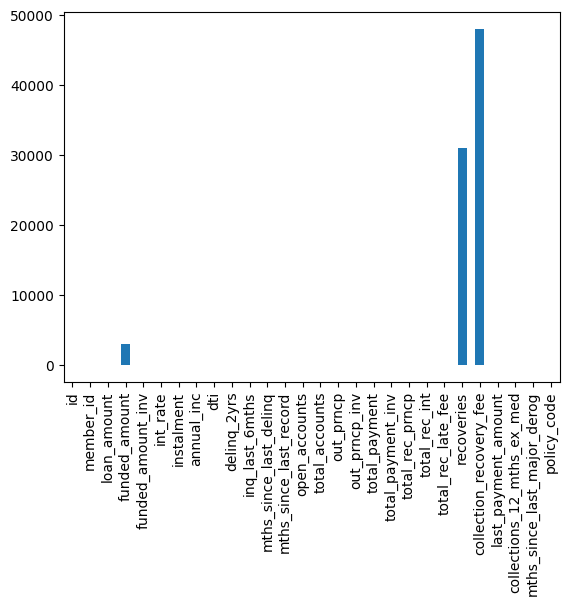

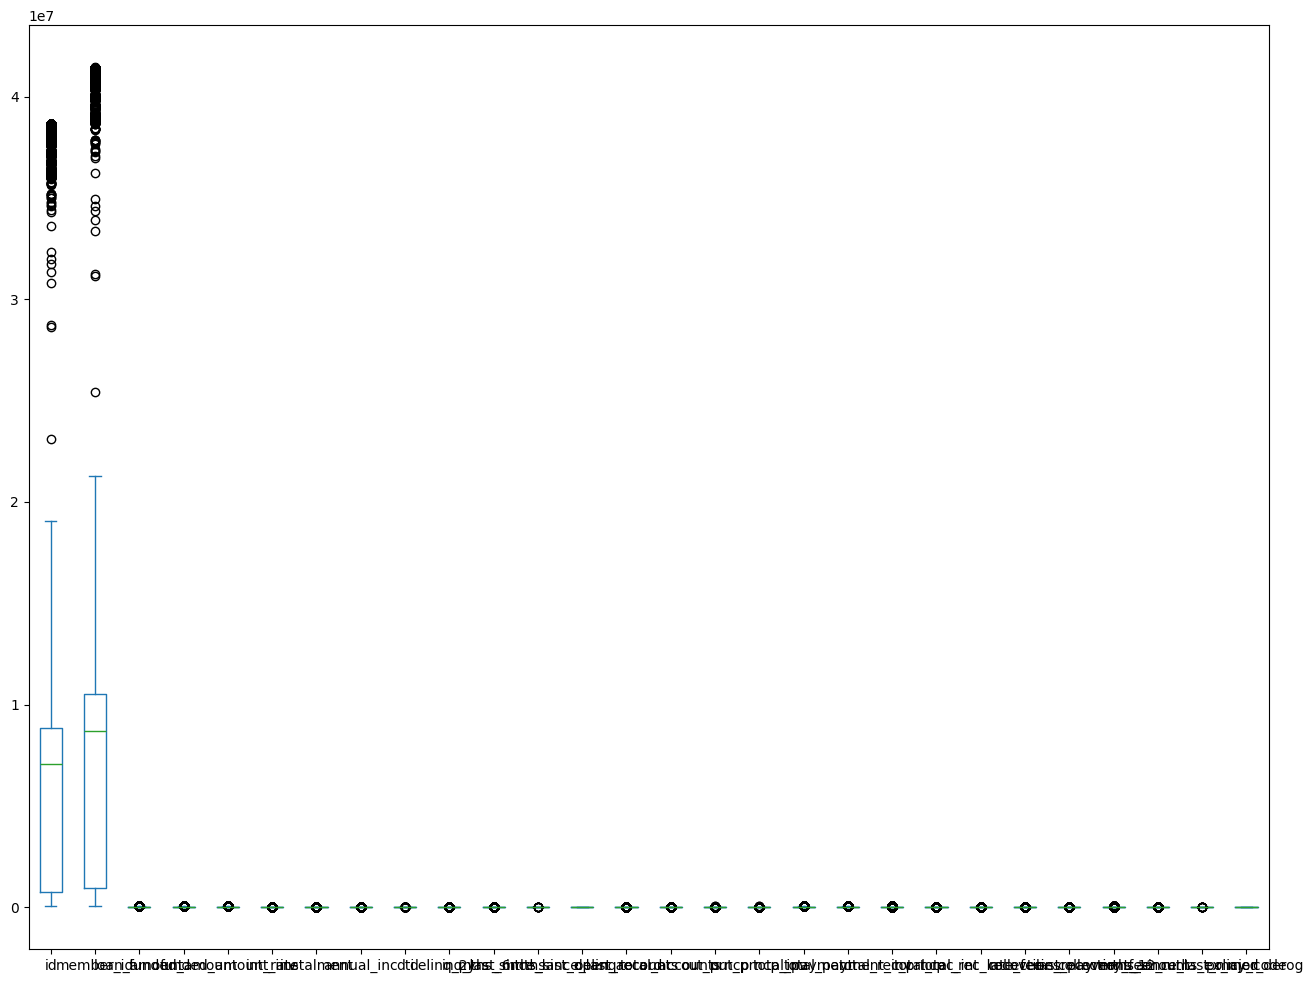

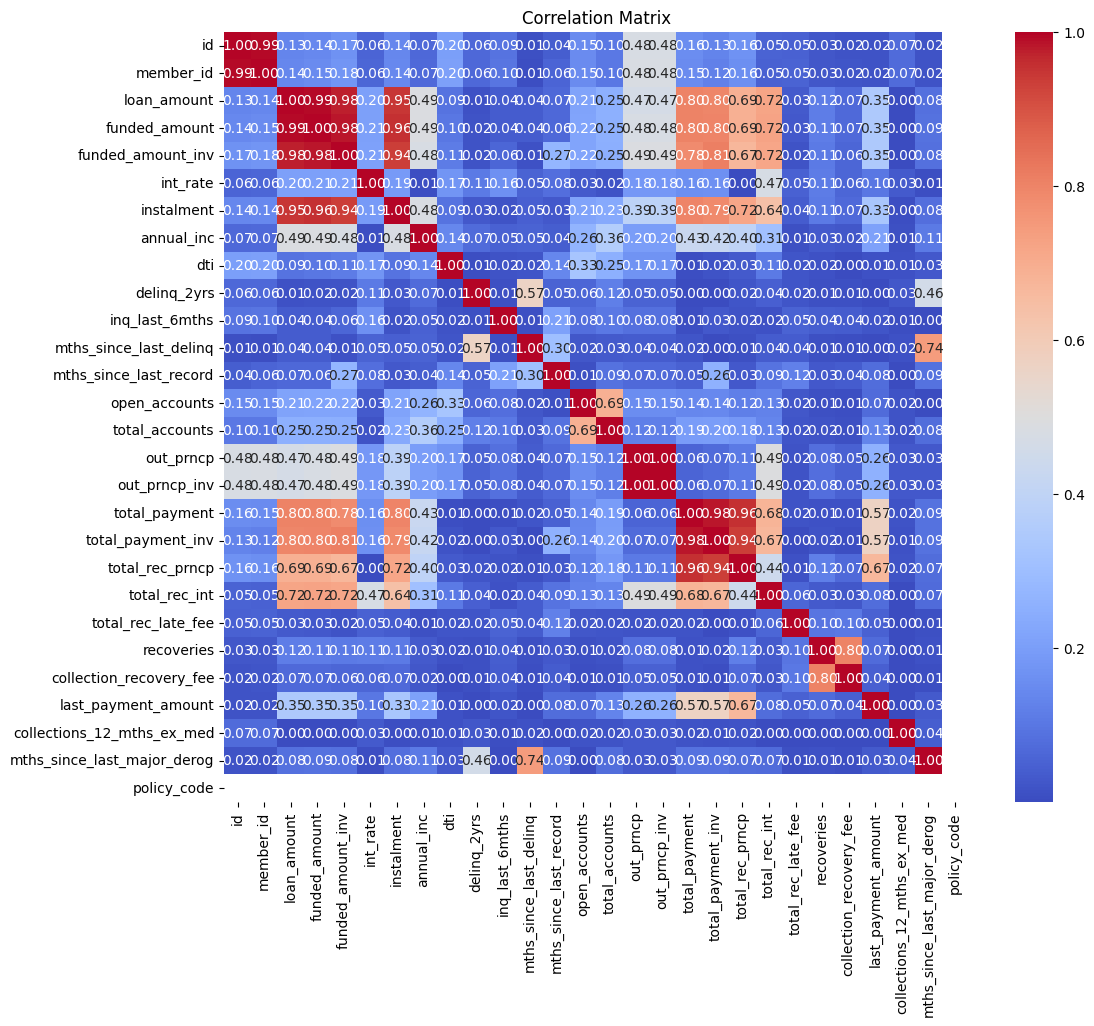

{'total_rec_prncp', 'id', 'funded_amount_inv', 'funded_amount', 'instalment', 'loan_amount', 'total_payment', 'total_payment_inv', 'member_id', 'out_prncp_inv', 'out_prncp'}
{('total_rec_prncp', 'total_payment_inv'), ('out_prncp', 'out_prncp_inv'), ('funded_amount', 'loan_amount'), ('instalment', 'loan_amount'), ('loan_amount', 'funded_amount_inv'), ('funded_amount_inv', 'instalment'), ('loan_amount', 'funded_amount'), ('id', 'member_id'), ('total_payment', 'total_rec_prncp'), ('funded_amount', 'instalment'), ('total_rec_prncp', 'total_payment'), ('out_prncp_inv', 'out_prncp'), ('funded_amount_inv', 'funded_amount'), ('funded_amount', 'funded_amount_inv'), ('instalment', 'funded_amount_inv'), ('total_payment_inv', 'total_rec_prncp'), ('total_payment_inv', 'total_payment'), ('instalment', 'funded_amount'), ('member_id', 'id'), ('funded_amount_inv', 'loan_amount'), ('loan_amount', 'instalment'), ('total_payment', 'total_payment_inv')}
['out_prncp_inv', 'total_payment_inv', 'total_rec_prn

In [9]:
'''
Here we test the class by first running an instance of the class under the variable 'test' and the input of our locally stored credentials.yaml file
Then we can run our methods from the test instance
'''

test = DataTransform(loan_payments_table)

check_id = test.check_id_unique()

#term_months_into_years = test.str_to_int()

test = DataFrameInfo(loan_payments_table)

test.column_data_types()

test.get_median()

test.get_standard_deviation()

test.get_mean()

funded_amount_mean = test.get_mean()

test.count_categorical_values()

test.get_shape()

test = DataFrameTransform(loan_payments_table)

test.null_values()

#loan_payments_table = test.drop_columns()

test.impute_columns()

test.plot_null()

test.reduce_skew()

test.skewness()

test.plot_skew()

column = 'annual_inc'

test.remove_outliers(column)

test.plot_outliers()

test.overly_corr_col()

overly_correlated_columns = ['out_prncp_inv', 'total_payment_inv', 'total_rec_prncp', 'member_id', 'funded_amount_inv']

test.drop_overly_corr(overly_correlated_columns)

test.save_data(loan_payments_table) #save the loan payments table to the csv file

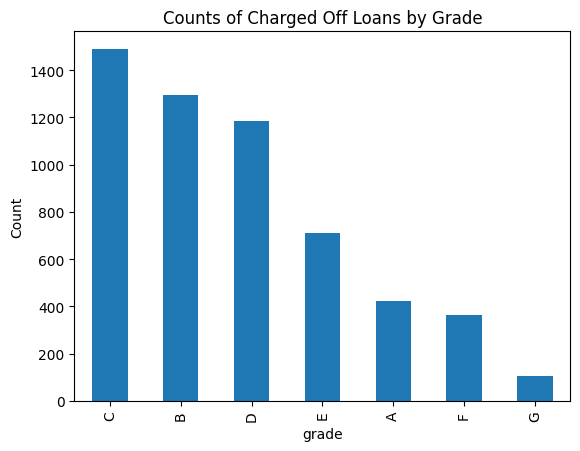

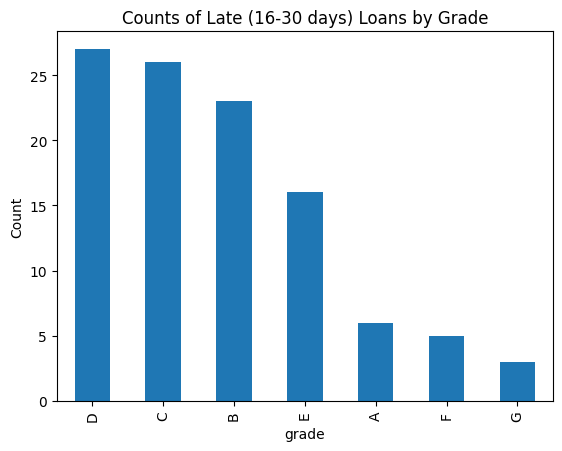

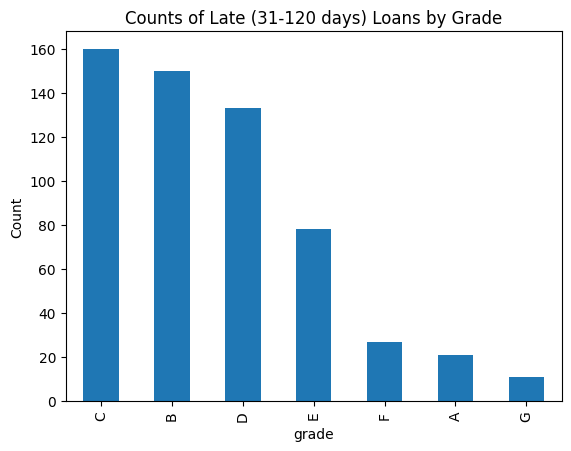

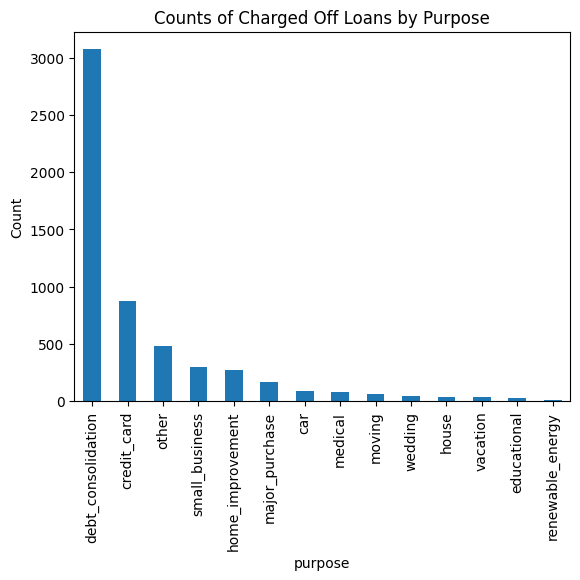

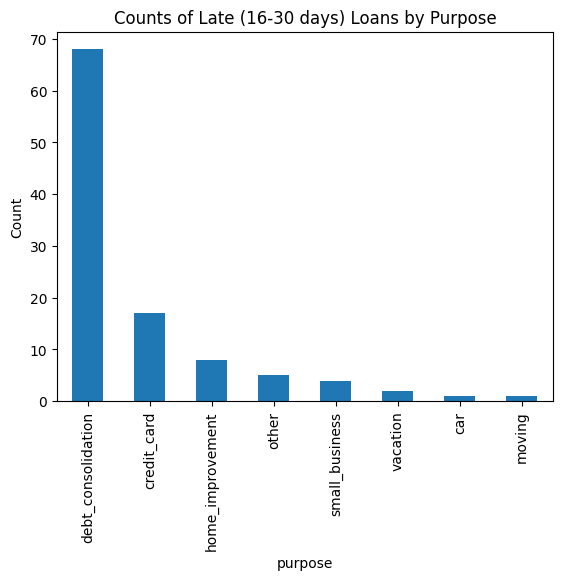

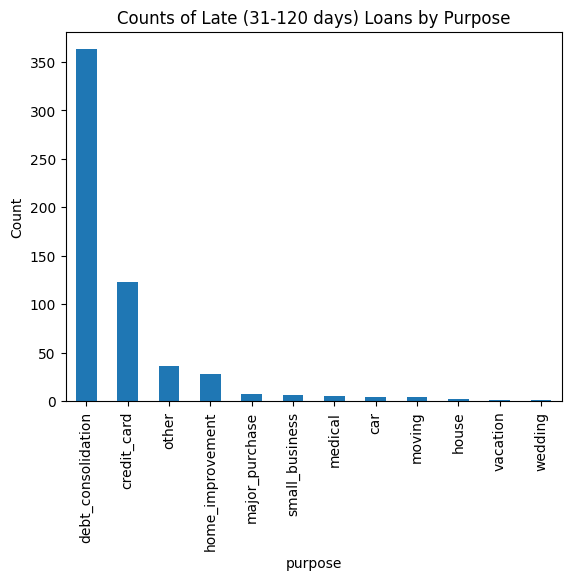

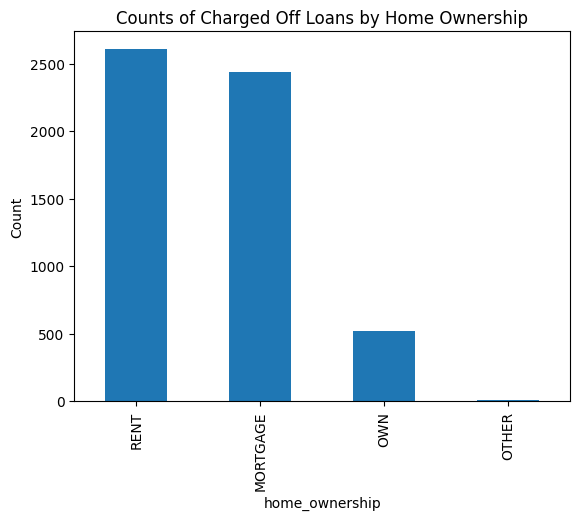

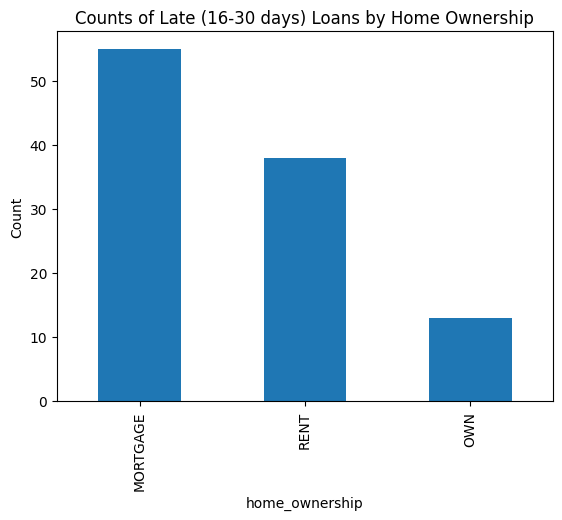

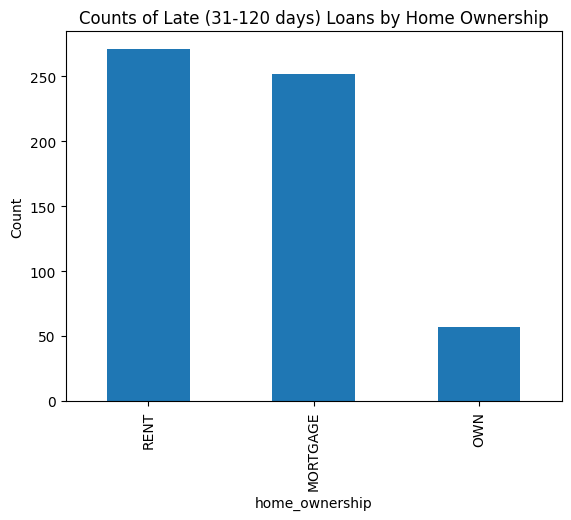

In [14]:
from pandasql import sqldf

class Analysis:

    def __init__(self, loan_payments_table):
        
        self.loan_payments_table = loan_payments_table

    def recovered_loans_percentage(self):
    
        recovered_loans = (loan_payments_table['total_payment']/loan_payments_table['loan_amount']) * 100
        
        print(recovered_loans.mean())

        unrecovered_loans = (100-recovered_loans.mean())

        data = {'Category': ['Recovered', 'Unrecovered'],
        'Values': [recovered_loans.mean(), (unrecovered_loans)]}

        # Create a DataFrame
        df = pd.DataFrame(data)

        # Plot the pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(df['Values'], labels=df['Category'], autopct='%1.1f%%')
        plt.title('Proportion of loan recovered vs unrecovered')
        plt.show()

        return
    
    def loan_loss(self):

        value_counts = loan_payments_table['loan_status'].value_counts()

        print(f'The percentage of charged off loans is {(round(value_counts['Charged Off']/len(loan_payments_table)*100, 2))}%')

        filtered_total_payment = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'total_payment']

        filtered_funded_amount = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'funded_amount']

        amount_lost = filtered_funded_amount - filtered_total_payment

        print(f"The total historical amount lost from charged off loans is {round(amount_lost.sum(),2)}")

        return
    
    def loan_projected_loss(self):

        filtered_term = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'term']

        filtered_instalment = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'instalment']

        filtered_term = filtered_term.dropna()
        
        filtered_instalment = filtered_instalment.dropna()

        filtered_term = filtered_term.str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        projected_loss = (filtered_instalment * filtered_term).sum()
        
        print(f"The total projected loss of the charged off loans is {round(projected_loss, 2)}")

        loan_payments_table['term'] = loan_payments_table['term'].dropna()
        
        loan_payments_table['instalment'] = loan_payments_table['instalment'].dropna()

        loan_payments_table['term'] = loan_payments_table['term'].str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        projected_revenue = (loan_payments_table['instalment'] * loan_payments_table['term']).sum()

        print(f"The total projected revenue without the charged off loans is {round(projected_revenue,2)}")

        projected_revenue_with_charged_off_loans = projected_revenue + projected_loss

        print(f"The total projected revenue with the charged off loans is {round(projected_revenue_with_charged_off_loans,2)}")

        df = pd.DataFrame({'Projected revenue with charged off loans': [0, projected_revenue_with_charged_off_loans],
        'Projected revenue without charged off loans': [0, projected_revenue]}, index=[0, 60])

        lines = df.plot.line()

        plt.xlabel('Months')

        plt.ylabel('Projected Revenue')

        return

    def late_customers_proportion(self):

        late_payments = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'loan_status']

        late_payments_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'loan_status']

        print(len(late_payments))

        print(len(late_payments_1))

        customer_late_payments = len(late_payments) + len(late_payments_1)
    
        print(f"The total number of customers that are late on their loans is {customer_late_payments}")

        late_loan_proportion = (customer_late_payments/len(loan_payments_table))*100

        print(f"The proportion of late loans to total loans is {round(late_loan_proportion,2)}%")

        return
    

    def late_loan_projected_loss(self):

        late_to_charged_off_loan_amount = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'loan_amount']

        late_to_charged_off_total_payment = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'total_payment']

        late_to_charged_off_loan_amount_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'loan_amount']

        late_to_charged_off_total_payment_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'total_payment']
        
        late_to_charged_off = late_to_charged_off_loan_amount - late_to_charged_off_total_payment

        late_to_charged_off_1 = late_to_charged_off_loan_amount_1 - late_to_charged_off_total_payment_1

        late_to_charged_off = late_to_charged_off.sum()

        late_to_charged_off_1 = late_to_charged_off_1.sum()

        print(f"If all late loans were switched to charged off, the loss would be {late_to_charged_off+late_to_charged_off_1}")



        late_instalment = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'instalment']

        late_term = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'term']

        late_instalment_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'instalment']

        late_term_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'term']

#        late_term = late_term.str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

#        late_term_1 = late_term_1.str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        projected_loss = ((late_instalment * late_term).sum()) + ((late_instalment_1 * late_term_1).sum())

        print(f"The company would incur this much projected loss if all the late loans were charged off {projected_loss}")


        
        loan_payments_table['term'] = loan_payments_table['term'].dropna()
        
        loan_payments_table['instalment'] = loan_payments_table['instalment'].dropna()

#        loan_payments_table['term'] = loan_payments_table['term'].str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        projected_revenue = (loan_payments_table['instalment'] * loan_payments_table['term']).sum()

        
        filtered_term = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'term']

        filtered_instalment = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'instalment']

        filtered_term = filtered_term.dropna()
        
        filtered_instalment = filtered_instalment.dropna()

        #filtered_term = filtered_term.str.replace('36 months', '36').str.replace('60 months', '60').astype(float)

        charged_off_loans = (filtered_instalment * filtered_term).sum()


        potential_charged_off_percentage = ((projected_loss + charged_off_loans)/projected_revenue)*100

        print(potential_charged_off_percentage)

        print(f"if late payment customers had their loans turned to charged off, the percentage of projected revenue would be {round(potential_charged_off_percentage,2)}%")


        return

    def indicators_of_loss(self):

        charged_off_grade = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'grade']

        late_grade = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'grade']

        late_grade_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'grade']
        

        charged_off_grade.value_counts().plot(kind='bar')

        plt.ylabel('Count')

        plt.title('Counts of Charged Off Loans by Grade')

        plt.show()

        late_grade.value_counts().plot(kind='bar')

        plt.ylabel('Count')

        plt.title('Counts of Late (16-30 days) Loans by Grade') 

        plt.show()
       
        late_grade_1.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Late (31-120 days) Loans by Grade')

        plt.show()

        charged_off_purpose = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'purpose']

        charged_off_purpose.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Charged Off Loans by Purpose')

        plt.show()

        late_purpose = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'purpose']

        late_purpose.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Late (16-30 days) Loans by Purpose')

        plt.show()

        late_purpose_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'purpose']

        late_purpose_1.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Late (31-120 days) Loans by Purpose')

        plt.show()

        charged_off_purpose = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Charged Off', 'home_ownership']

        charged_off_purpose.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Charged Off Loans by Home Ownership')

        plt.show()

        late_purpose = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (16-30 days)', 'home_ownership']

        late_purpose.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Late (16-30 days) Loans by Home Ownership')

        plt.show()

        late_purpose_1 = loan_payments_table.loc[loan_payments_table['loan_status'] == 'Late (31-120 days)', 'home_ownership']

        late_purpose_1.value_counts().plot(kind='bar')

        plt.ylabel('Count') 

        plt.title('Counts of Late (31-120 days) Loans by Home Ownership')

        plt.show()

        return


        
    

test = Analysis(loan_payments_table)

#test.recovered_loans_percentage()

#test.loan_loss()

#test.loan_projected_loss()

# test.late_customers_proportion()

#test.late_loan_projected_loss()

test.indicators_of_loss()